# **Klasifikasi Jenis Sampah**

In [1]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Jumlah GPU:", torch.cuda.device_count())

if torch.cuda.is_available():
    print("Nama GPU:", torch.cuda.get_device_name(0))
else:
    print("PyTorch masih pakai CPU")


PyTorch version: 2.7.1+cu118
CUDA available: True
Jumlah GPU: 1
Nama GPU: NVIDIA GeForce RTX 3050 Laptop GPU


## **Import Library**

In [3]:
# 1. Library Dasar & Manipulasi File
import os
import shutil
import random
import json
import gc
import time

# 2. Library Pengolahan Data & Statistik
import numpy as np
import pandas as pd

# 3. Library Utama Deep Learning (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# 4. Library Visualisasi
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from PIL import Image

# 5. Library Evaluasi Model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## **Load Dataset**

In [ ]:
# Path dataset (RELATIVE PATH)
train_dir = "DATASET/TRAIN"
test_dir  = "DATASET/TEST"

def hitung_data(directory, nama_set):
    print(f"--- {nama_set} ---")
    
    if not os.path.exists(directory):
        print(f"❌ Folder {directory} tidak ditemukan\n")
        return
    
    for kategori in os.listdir(directory):
        path_kategori = os.path.join(directory, kategori)
        if os.path.isdir(path_kategori):
            jumlah = len([
                f for f in os.listdir(path_kategori)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
            print(f"Kategori {kategori}: {jumlah} gambar")
    
    print("")

# Jalankan
hitung_data(train_dir, "TRAINING SET")
hitung_data(test_dir, "TESTING SET")

--- TRAINING SET ---
Kategori O: 12565 gambar
Kategori R: 9999 gambar

--- TESTING SET ---
Kategori O: 1401 gambar
Kategori R: 1112 gambar



## **Exploratory Data Analysis**

### **Visualisasi Distribusi Kelas**

     Set Kelas  Jumlah
0  TRAIN     O   12565
1  TRAIN     R    9999
2   TEST     O    1401
3   TEST     R    1112


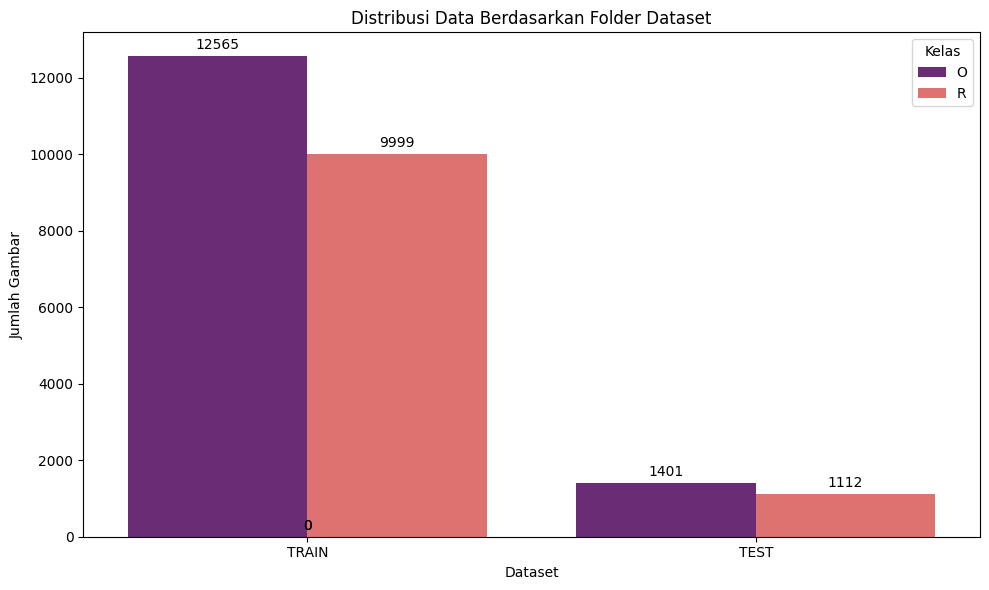

In [ ]:
base_path = "DATASET"
sets = ["TRAIN", "TEST"]
categories = ["O", "R"]   # O = Organik, R = Residu (contoh)


data = []

for s in sets:
    for cat in categories:
        path = os.path.join(base_path, s, cat)
        
        if os.path.exists(path):
            count = len([
                f for f in os.listdir(path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
        else:
            count = 0
        
        data.append({
            "Set": s,
            "Kelas": cat,
            "Jumlah": count
        })


# DATAFRAME
df_counts = pd.DataFrame(data)
print(df_counts)

# VISUALISASI
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_counts,
    x="Set",
    y="Jumlah",
    hue="Kelas",
    palette="magma"
)

plt.title("Distribusi Data Berdasarkan Folder Dataset")
plt.ylabel("Jumlah Gambar")
plt.xlabel("Dataset")

# Label angka di atas bar
ax = plt.gca()
for p in ax.patches:
    ax.annotate(
        int(p.get_height()),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 8),
        textcoords="offset points"
    )

plt.tight_layout()
plt.show()

### **Sampel Gambar**

Sampel Sampah Organik (O):


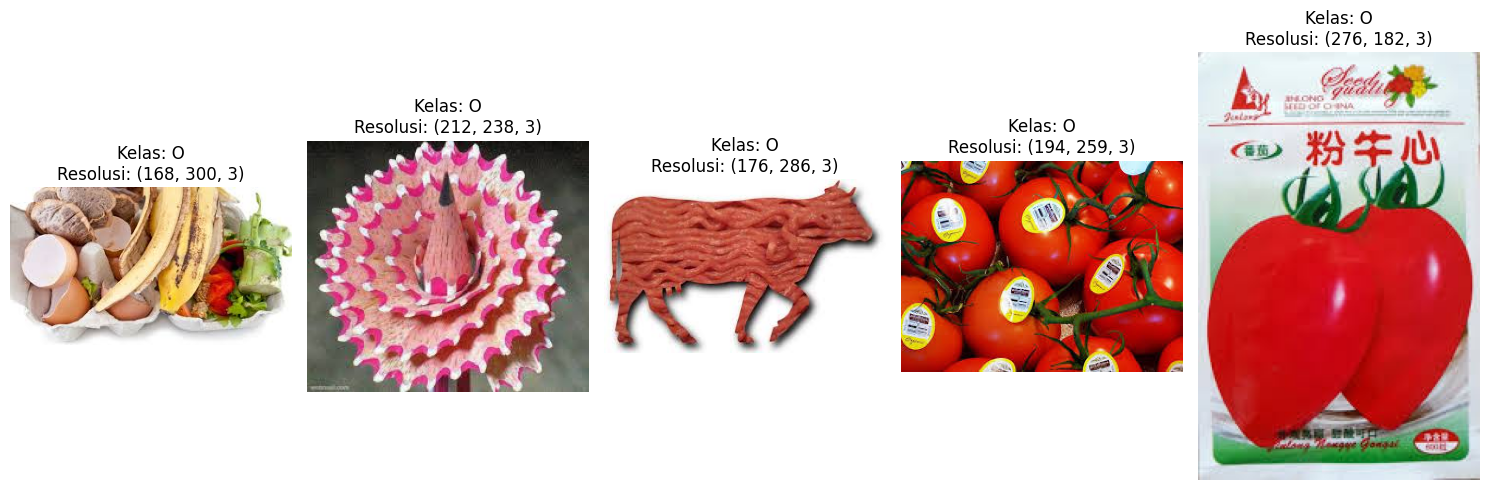


Sampel Sampah Daur Ulang (R):


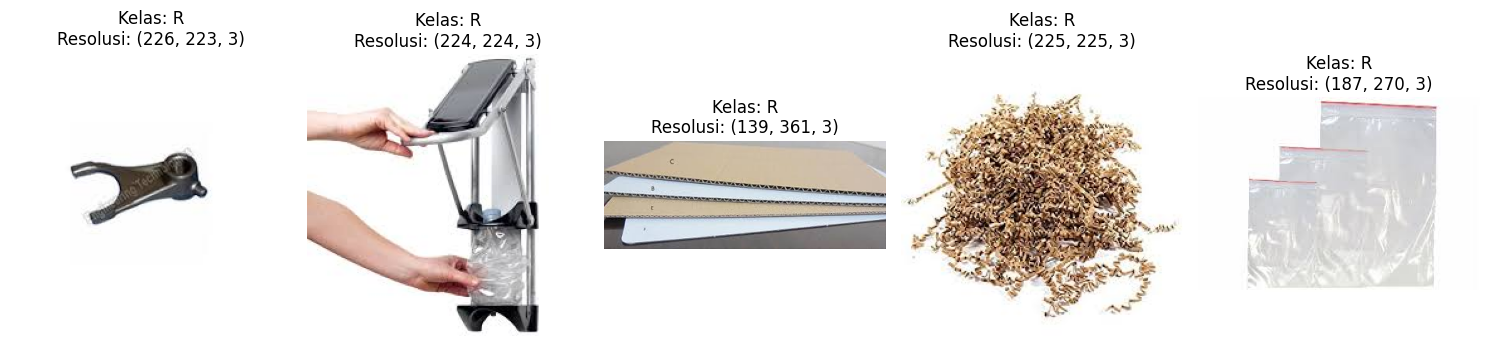

In [ ]:
def tampilkan_sampel(base_path, kategori, jumlah=5):
    folder_path = os.path.join(base_path, kategori)

    if not os.path.exists(folder_path):
        print(f"Folder tidak ditemukan: {folder_path}")
        return

    # Ambil hanya file gambar
    file_list = [
        f for f in os.listdir(folder_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]

    if len(file_list) < jumlah:
        print(f"Jumlah gambar kurang dari {jumlah} pada kelas {kategori}")
        return

    file_names = random.sample(file_list, jumlah)

    plt.figure(figsize=(15, 5))
    for i, file_name in enumerate(file_names):
        img_path = os.path.join(folder_path, file_name)
        img = mpimg.imread(img_path)

        plt.subplot(1, jumlah, i + 1)
        plt.imshow(img)
        plt.title(f"Kelas: {kategori}\nResolusi: {img.shape}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# PATH TRAINING SET
train_path = "DATASET/TRAIN"

print("Sampel Sampah Organik (O):")
tampilkan_sampel(train_path, "O")

print("\nSampel Sampah Daur Ulang (R):")
tampilkan_sampel(train_path, "R")

### **Analisis Dimensi Gambar**

In [ ]:
def cek_dimensi_rata_rata(folder_path, kelas='O', n_samples=100):
    widths, heights = [], []

    class_path = os.path.join(folder_path, kelas)

    if not os.path.exists(class_path):
        print(f"Folder tidak ditemukan: {class_path}")
        return

    # Ambil hanya file gambar
    files = [
        f for f in os.listdir(class_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]

    if len(files) == 0:
        print(f"Tidak ada file gambar di folder {kelas}")
        return

    # Batasi jumlah sampel jika data kurang
    sample_size = min(n_samples, len(files))
    sampled_files = random.sample(files, sample_size)

    for f in sampled_files:
        with Image.open(os.path.join(class_path, f)) as img:
            w, h = img.size
            widths.append(w)
            heights.append(h)

    print(f"📊 Dimensi rata-rata dari {sample_size} sampel (Kelas {kelas}):")
    print(f"Lebar  : {sum(widths)/sample_size:.2f} px")
    print(f"Tinggi : {sum(heights)/sample_size:.2f} px")


# PATH TRAINING SET
train_path = "DATASET/TRAIN"

cek_dimensi_rata_rata(train_path, kelas='O', n_samples=100)
cek_dimensi_rata_rata(train_path, kelas='R', n_samples=100)

📊 Dimensi rata-rata dari 100 sampel (Kelas O):
Lebar  : 259.51 px
Tinggi : 197.90 px
📊 Dimensi rata-rata dari 100 sampel (Kelas R):
Lebar  : 242.53 px
Tinggi : 211.75 px


## **Split Data**

In [ ]:
# PATH DATASET (LOKAL)
base_dir = "DATASET"
train_dir = os.path.join(base_dir, "TRAIN")
val_dir = os.path.join(base_dir, "VAL")

# Buat folder VAL jika belum ada
os.makedirs(val_dir, exist_ok=True)

# Rasio split
val_ratio = 0.2
random.seed(42)  

# SPLIT PER KELAS
for kelas in os.listdir(train_dir):
    path_kelas_train = os.path.join(train_dir, kelas)
    path_kelas_val = os.path.join(val_dir, kelas)

    if not os.path.isdir(path_kelas_train):
        continue

    os.makedirs(path_kelas_val, exist_ok=True)

    # Ambil hanya file gambar
    images = [
        f for f in os.listdir(path_kelas_train)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]

    random.shuffle(images)

    n_val = int(len(images) * val_ratio)
    val_images = images[:n_val]

    # Pindahkan file
    for img in val_images:
        src = os.path.join(path_kelas_train, img)
        dst = os.path.join(path_kelas_val, img)

        if os.path.exists(src):
            shutil.move(src, dst)

    print(f"Kelas {kelas}: {len(images)-n_val} TRAIN | {n_val} VAL")

print("\n✅ Split data TRAIN → VAL selesai")

Kelas O: 10052 TRAIN | 2513 VAL
Kelas R: 8000 TRAIN | 1999 VAL

✅ Split data TRAIN → VAL selesai


### **Visualisasi Data After Splitting**

     Set Class  Count
0  TRAIN     O  10052
1  TRAIN     R   8000
2    VAL     O   2513
3    VAL     R   1999
4   TEST     O   1401
5   TEST     R   1112


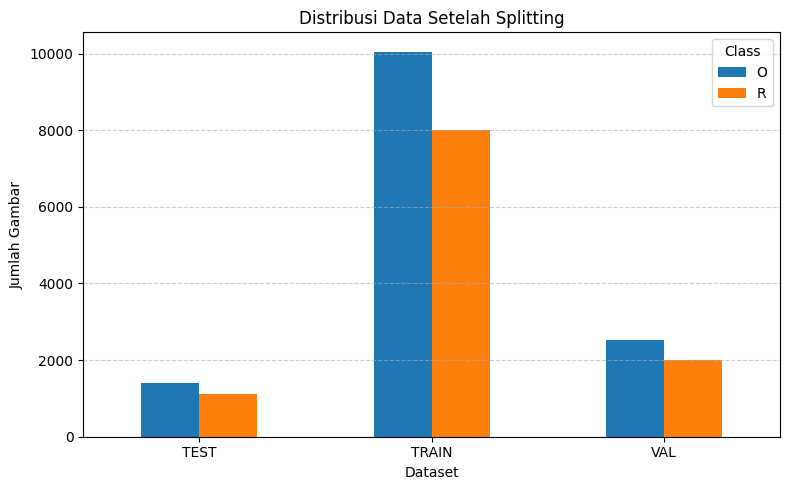

In [ ]:
# PATH DATASET (LOKAL)
base_dir = "DATASET"   
sets = ["TRAIN", "VAL", "TEST"]
classes = ["O", "R"]


# HITUNG JUMLAH DATA
data = []

for s in sets:
    for c in classes:
        path = os.path.join(base_dir, s, c)
        if os.path.exists(path):
            count = len([
                f for f in os.listdir(path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
        else:
            count = 0

        data.append([s, c, count])

df = pd.DataFrame(data, columns=["Set", "Class", "Count"])

print(df)


# VISUALISASI
pivot_df = df.pivot(index="Set", columns="Class", values="Count")

pivot_df.plot(
    kind="bar",
    figsize=(8, 5),
    title="Distribusi Data Setelah Splitting"
)

plt.xlabel("Dataset")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## **Preprocessing & Augmentasi**

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42

TRAIN_DIR = "DATASET/TRAIN"
VAL_DIR   = "DATASET/VAL"
TEST_DIR  = "DATASET/TEST"


# Transforms - TRAIN
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2),  # mirip brightness_range
    transforms.ToTensor(),                   # mengubah ke tensor dan normalisasi 0-1
])


# Transforms - VAL & TEST
val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])


# Dataset
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)
val_dataset   = datasets.ImageFolder(root=VAL_DIR, transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(root=TEST_DIR, transform=val_test_transforms)


# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


# Cek kelas
print("✅ Data augmentation & preprocessing siap digunakan")
print("Label kelas:", train_dataset.class_to_idx)

✅ Data augmentation & preprocessing siap digunakan
Label kelas: {'O': 0, 'R': 1}


## **Neural Network base (non-pretrained)**

### **Build Model**

In [ ]:
class BaseCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(BaseCNN, self).__init__()
        
        # Conv2D(32, (3,3)) + MaxPooling2D(2,2)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Conv2D(64, (3,3)) + MaxPooling2D(2,2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Conv2D(128, (3,3)) + MaxPooling2D(2,2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Flatten + Dense(128) + Dropout(0.5) + Dense(2)
        # Perhitungan input linear: (224-2)/2 -> (111-2)/2 -> (54-2)/2 = 26x26
        # Hasil akhir setelah 3x pooling adalah 26x26 (dengan asumsi tanpa padding)
        self.fc1 = nn.Linear(128 * 26 * 26, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Layer 1
        x = self.pool1(F.relu(self.conv1(x)))
        # Layer 2
        x = self.pool2(F.relu(self.conv2(x)))
        # Layer 3
        x = self.pool3(F.relu(self.conv3(x)))
        
        # Flatten
        x = torch.flatten(x, 1)
        
        # Fully Connected
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x) 
        return x

# Inisialisasi Model
model_base = BaseCNN(num_classes=2)

# Set Optimizer (Sesuai Adam learning_rate=1e-4)
optimizer = torch.optim.Adam(model_base.parameters(), lr=1e-4)

# Set Loss Function (Sesuai categorical_crossentropy)
criterion = nn.CrossEntropyLoss()

print(model_base)

BaseCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=86528, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


### **Training Model**

In [ ]:
# 1. SETUP & KONFIGURASI
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("outputs", exist_ok=True)

def run_train_maraton(model, model_name, train_loader, val_loader, epochs=7, patience=3):
    model.to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    
    best_loss = float('inf')
    counter = 0
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(epochs):
        # --- PHASE TRAINING ---
        model.train()
        train_l, train_c, total = 0, 0, 0
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(device), lbls.to(device).long().squeeze()
            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, lbls)
            loss.backward(); optimizer.step()
            train_l += loss.item()
            train_c += (out.argmax(1) == lbls).sum().item()
            total += lbls.size(0)
        
        # --- PHASE VALIDASI ---
        model.eval()
        val_l, val_c, v_total = 0, 0, 0
        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device).long().squeeze()
                out = model(imgs)
                val_l += criterion(out, lbls).item()
                val_c += (out.argmax(1) == lbls).sum().item()
                v_total += lbls.size(0)

        # Simpan Stats
        metrics = {
            'loss': train_l/len(train_loader), 'accuracy': train_c/total,
            'val_loss': val_l/len(val_loader), 'val_accuracy': val_c/v_total
        }
        for k, v in metrics.items(): history[k].append(v)
        
        print(f"[{model_name}] Epoch {epoch+1}: Loss {metrics['loss']:.4f}, Acc {metrics['accuracy']:.4f}, Val Loss {metrics['val_loss']:.4f}")

        # CHECKPOINT & EARLY STOPPING
        if metrics['val_loss'] < best_loss:
            best_loss = metrics['val_loss']
            torch.save(model.state_dict(), f"outputs/{model_name}_best.pth")
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered!"); break

    np.save(f"outputs/history_{model_name}.npy", history)
    return history

# 2. EKSEKUSI (Bisa Anda tambah/kurang list modelnya di sini)
target_models = [
    ("Base_CNN", model_base),
]

for name, m in target_models:
    run_train_maraton(m, name, train_loader, val_loader)
    # Bersihkan Memori setelah satu model selesai
    gc.collect(); torch.cuda.empty_cache()

print("Semua Training Selesai!")

[Base_CNN] Epoch 1: Loss 0.4474, Acc 0.7984, Val Loss 0.3968
[Base_CNN] Epoch 2: Loss 0.4003, Acc 0.8279, Val Loss 0.3722
[Base_CNN] Epoch 3: Loss 0.3864, Acc 0.8339, Val Loss 0.3761
[Base_CNN] Epoch 4: Loss 0.3701, Acc 0.8427, Val Loss 0.3575
[Base_CNN] Epoch 5: Loss 0.3592, Acc 0.8491, Val Loss 0.3446
[Base_CNN] Epoch 6: Loss 0.3523, Acc 0.8528, Val Loss 0.3385
[Base_CNN] Epoch 7: Loss 0.3460, Acc 0.8570, Val Loss 0.3322
Semua Training Selesai!


### **Visualisasi Hasil Training**

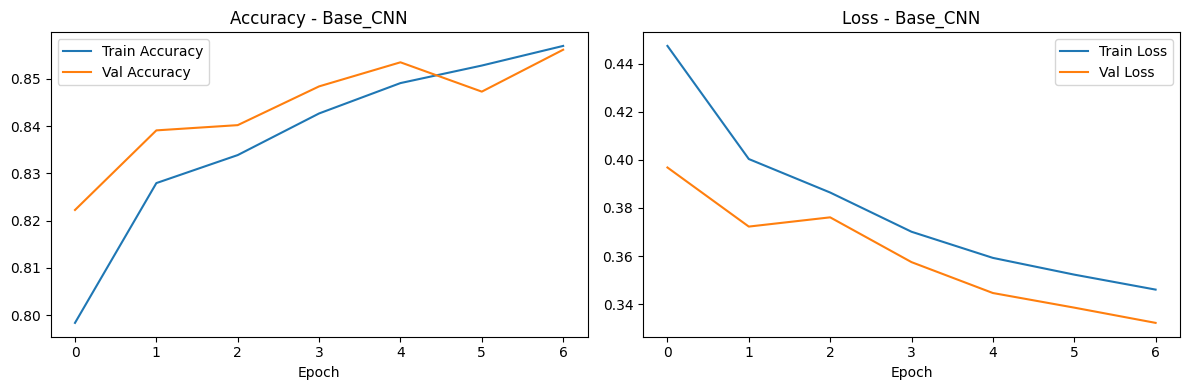

In [ ]:
def plot_history(model_name):
    history = np.load(f"outputs/history_{model_name}.npy", allow_pickle=True).item()
    
    plt.figure(figsize=(12, 4))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.title(f'Accuracy - {model_name}')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'Loss - {model_name}')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Contoh cara pakai:
plot_history("Base_CNN")

### **Evaluasi Model**


--- Classification Report: Base_CNN ---
                precision    recall  f1-score   support

   Organic (O)       0.83      0.96      0.89      1401
Recyclable (R)       0.94      0.74      0.83      1112

      accuracy                           0.86      2513
     macro avg       0.88      0.85      0.86      2513
  weighted avg       0.87      0.86      0.86      2513



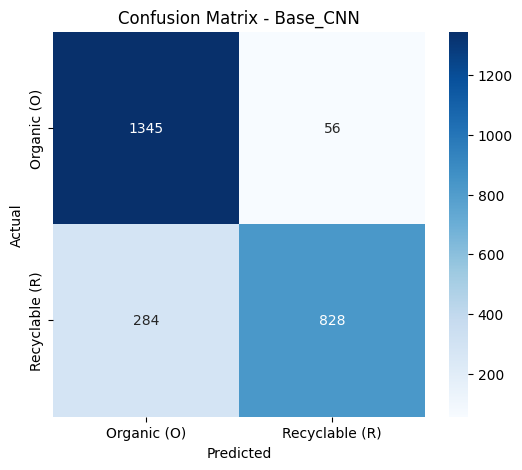

In [ ]:
def evaluate_final(model, model_name, test_loader, device):
    # 1. Load Bobot Terbaik
    model.load_state_dict(torch.load(f"outputs/{model_name}_best.pth"))
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    # 2. Ambil Prediksi dari Test Loader
    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs = imgs.to(device)
            out = model(imgs)
            preds = out.argmax(1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(lbls.numpy())
    
    # 3. Print Classification Report
    print(f"\n--- Classification Report: {model_name} ---")
    # Ganti target_names sesuai urutan kelas Anda (misal: ['O', 'R'])
    # Pastikan urutannya benar sesuai dataset_from_directory
    target_names = ['Organic (O)', 'Recyclable (R)']
    print(classification_report(all_labels, all_preds, target_names=target_names))
    
    # 4. Tampilkan Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Pastikan test_loader sudah dibuat sebelumnya
evaluate_final(model_base, "Base_CNN", test_loader, device)

### **Pediksi Label Asli vs Prediksi**

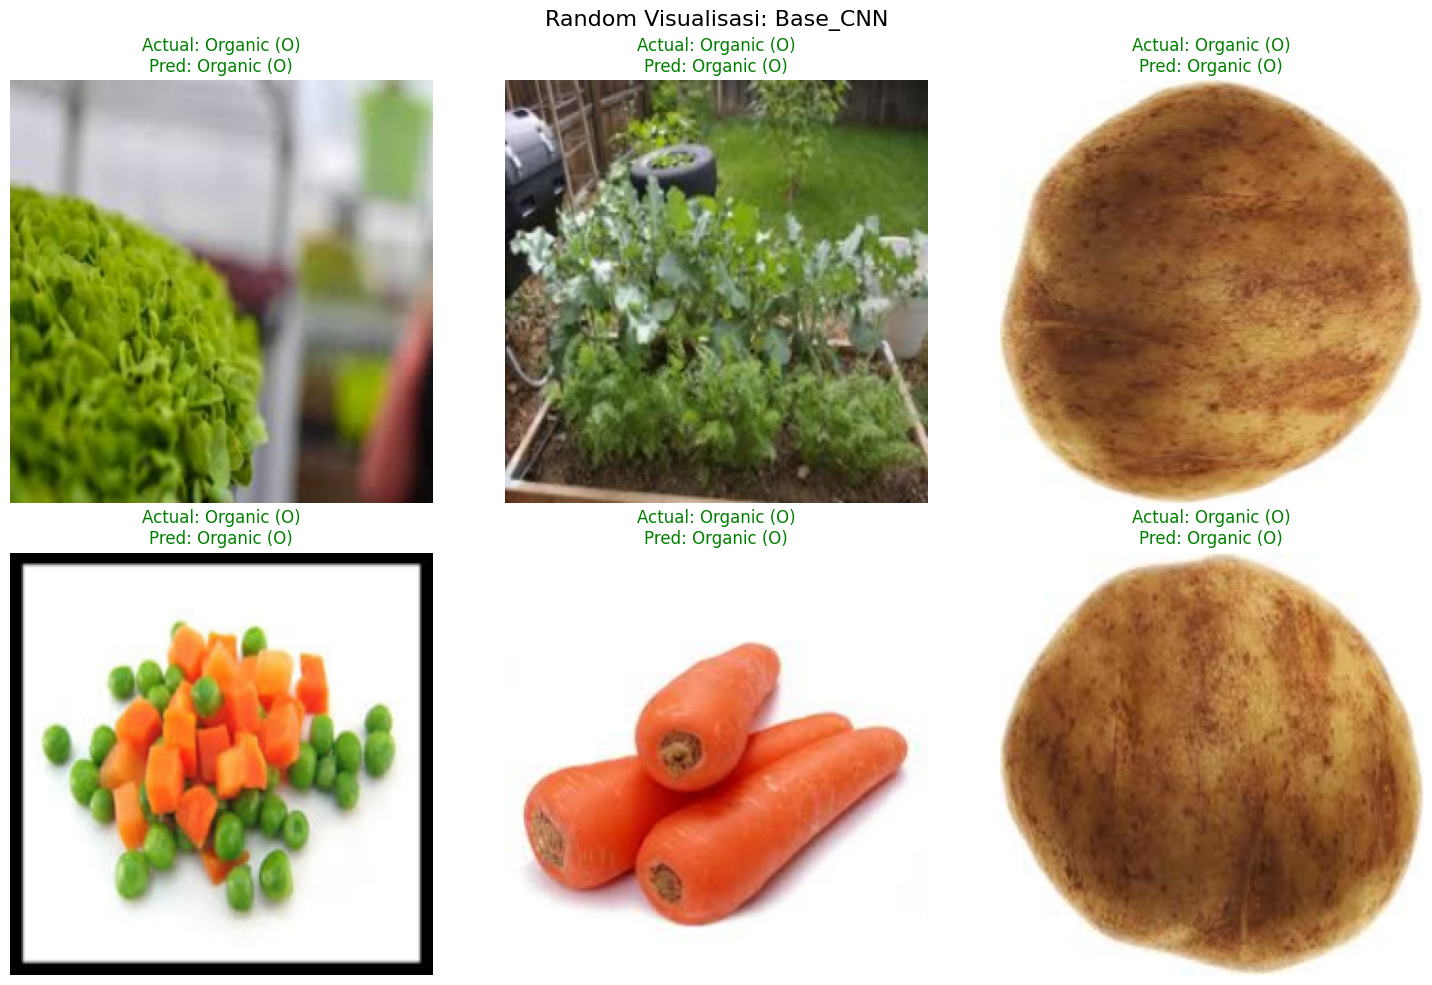

In [ ]:
def visualize_random_predictions(model, model_name, test_loader, device, num_images=6):
    # 1. Load bobot terbaik
    model.load_state_dict(torch.load(f"outputs/{model_name}_best.pth"))
    model.to(device)
    model.eval()
    
    class_names = ['Organic (O)', 'Recyclable (R)']
    
    # 2. Ambil SEMUA data dari test_loader (atau satu batch besar)
    # Kita ambil batch secara acak dari loader
    all_batches = list(test_loader)
    random_batch = random.choice(all_batches)
    images, labels = random_batch
    
    # Ambil indeks acak dari batch tersebut
    indices = random.sample(range(len(images)), min(num_images, len(images)))
    
    # 3. Prediksi
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        img_tensor = images[idx].unsqueeze(0).to(device) # Tambah dimensi batch (1, C, H, W)
        
        with torch.no_grad():
            output = model(img_tensor)
            pred = output.argmax(1).item()
        
        actual_idx = int(labels[idx])
        
        # 4. Visualisasi
        plt.subplot(2, 3, i + 1)
        
        # Konversi tensor ke gambar (C, H, W) -> (H, W, C)
        img = images[idx].permute(1, 2, 0).cpu().numpy()
        img = (img - img.min()) / (img.max() - img.min()) 
        
        plt.imshow(img)
        
        actual = class_names[actual_idx]
        predicted = class_names[pred]
        color = "green" if actual == predicted else "red"
        
        plt.title(f"Actual: {actual}\nPred: {predicted}", color=color)
        plt.axis("off")
    
    plt.suptitle(f"Random Visualisasi: {model_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Jalankan
visualize_random_predictions(model_base, "Base_CNN", test_loader, device)

## **Model VGG16**

### **Build Model**

In [ ]:
def build_vgg16(num_classes=2):
    # 1. Load model VGG16 dengan bobot ImageNet (Pre-trained)
    model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    
    # 2. FREEZING (Membekukan Layer Konvolusi)
    # Kita bekukan agar bobot fitur dasar tidak berubah selama training
    for param in model.features.parameters():
        param.requires_grad = False
        
    # 3. MODIFIKASI CLASSIFIER (Bagian Akhir)
    # VGG16 memiliki classifier di model.classifier yang terdiri dari beberapa layer.
    # Kita hanya perlu mengganti layer terakhir (index 6).
    num_ftrs = model.classifier[6].in_features
    
    # Ganti dengan layer Linear baru (Output = 2)
    model.classifier[6] = nn.Linear(num_ftrs, num_classes)
    
    return model

# Inisialisasi model
model_vgg16 = build_vgg16(num_classes=2)

# Cek struktur singkat
print(model_vgg16.classifier)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Nadzrul/.cache\torch\hub\checkpoints\vgg16-397923af.pth


100%|██████████| 528M/528M [00:52<00:00, 10.6MB/s] 


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)


In [ ]:
# Hapus variabel model sebelumnya jika masih ada di workspace
if 'model_base' in globals():
    del model_base

# Paksa pembersihan RAM dan VRAM
gc.collect()
torch.cuda.empty_cache()

print("Memori GPU telah dibersihkan. Siap untuk training VGG16.")

Memori GPU telah dibersihkan. Siap untuk training VGG16.


In [ ]:
class_names = ['Organic', 'Recyclable'] 
mapping = {i: name for i, name in enumerate(class_names)}

with open("outputs/label_mapping.json", "w") as f:
    json.dump(mapping, f)
print("Label mapping disimpan")

Label mapping disimpan


### **Training Model**

In [27]:
# Pastikan model_vgg16 sudah di-build di sel sebelumnya
target_models = [
    ("VGG16", model_vgg16),
]

# Kita jalankan loop training
for name, m in target_models:
    print(f"Memulai proses training untuk: {name}")
    history = run_train_maraton(
        model=m, 
        model_name=name, 
        train_loader=train_loader, 
        val_loader=val_loader, 
        epochs=10,    
        patience=3   
    )
    
    # Pembersihan setelah selesai
    gc.collect()
    torch.cuda.empty_cache()

print("Training VGG16 Selesai!")

Memulai proses training untuk: VGG16
[VGG16] Epoch 1: Loss 0.2545, Acc 0.8969, Val Loss 0.1844
[VGG16] Epoch 2: Loss 0.1992, Acc 0.9226, Val Loss 0.1969
[VGG16] Epoch 3: Loss 0.1751, Acc 0.9308, Val Loss 0.1730
[VGG16] Epoch 4: Loss 0.1608, Acc 0.9369, Val Loss 0.1742
[VGG16] Epoch 5: Loss 0.1411, Acc 0.9453, Val Loss 0.1605
[VGG16] Epoch 6: Loss 0.1334, Acc 0.9488, Val Loss 0.1893
[VGG16] Epoch 7: Loss 0.1190, Acc 0.9521, Val Loss 0.1880
[VGG16] Epoch 8: Loss 0.1111, Acc 0.9578, Val Loss 0.2090
Early stopping triggered!
Training VGG16 Selesai!


### **Visualisasi Hasil Training**

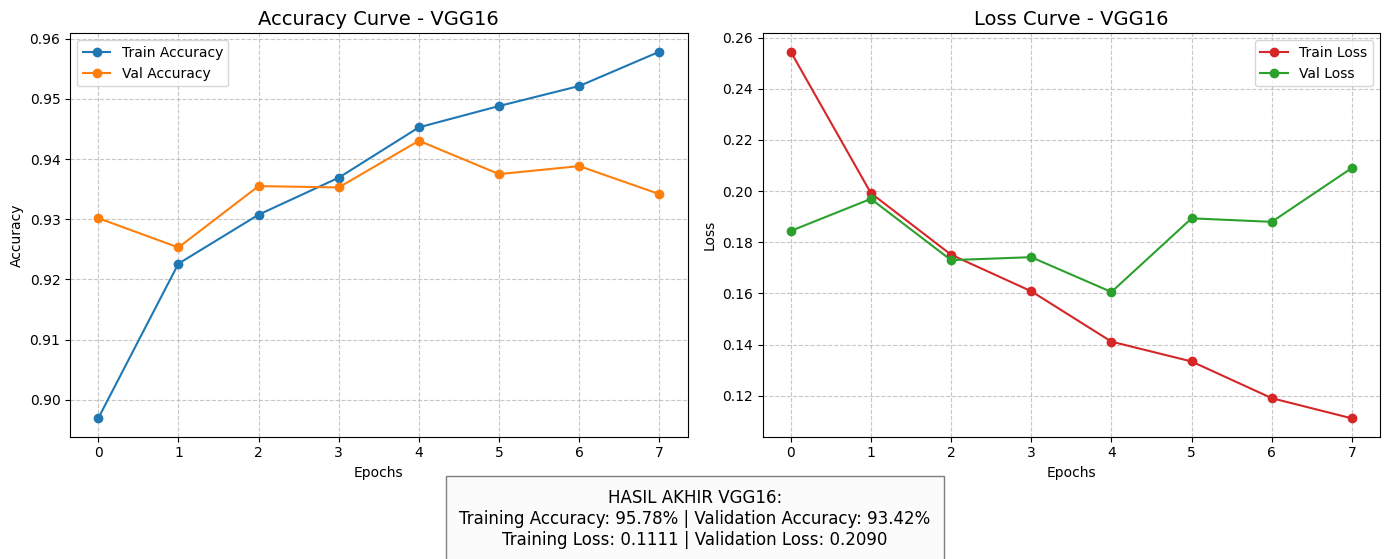

In [ ]:
def plot_training_results(model_name):
    # 1. Load data history
    history = np.load(f"outputs/history_{model_name}.npy", allow_pickle=True).item()
    
    # Ambil nilai terakhir untuk ditampilkan sebagai teks
    final_train_acc = history['accuracy'][-1]
    final_val_acc = history['val_accuracy'][-1]
    final_train_loss = history['loss'][-1]
    final_val_loss = history['val_loss'][-1]
    
    # 2. Buat Figure
    plt.figure(figsize=(14, 5))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy', marker='o', color='#1f77b4')
    plt.plot(history['val_accuracy'], label='Val Accuracy', marker='o', color='#ff7f0e')
    plt.title(f'Accuracy Curve - {model_name}', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss', marker='o', color='#d62728')
    plt.plot(history['val_loss'], label='Val Loss', marker='o', color='#2ca02c')
    plt.title(f'Loss Curve - {model_name}', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # 3. Tambahkan Teks Ringkasan di Bawah Gambar
    summary_text = (f"HASIL AKHIR {model_name}:\n"
                    f"Training Accuracy: {final_train_acc*100:.2f}% | Validation Accuracy: {final_val_acc*100:.2f}%\n"
                    f"Training Loss: {final_train_loss:.4f} | Validation Loss: {final_val_loss:.4f}")
    
    plt.figtext(0.5, -0.1, summary_text, ha="center", fontsize=12, 
                bbox={"facecolor":"#f9f9f9", "alpha":0.5, "pad":10})
    
    plt.tight_layout()
    plt.show()

# Jalankan untuk VGG16
plot_training_results("VGG16")

### **Evaluasi Model**

Sedang mengevaluasi VGG16 pada data test...

CLASSIFICATION REPORT: VGG16
                precision    recall  f1-score   support

   Organic (O)       0.88      0.98      0.93      1401
Recyclable (R)       0.97      0.83      0.90      1112

      accuracy                           0.91      2513
     macro avg       0.93      0.91      0.91      2513
  weighted avg       0.92      0.91      0.91      2513



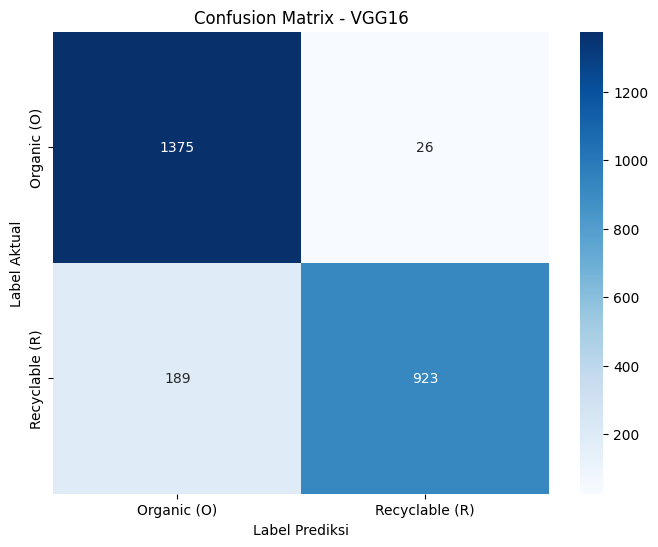

In [ ]:
def evaluasi_lengkap_vgg16(model, model_name, test_loader, device):
    # 1. Load Bobot Terbaik
    model.load_state_dict(torch.load(f"outputs/{model_name}_best.pth"))
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    # 2. Ambil Prediksi dari Data Test
    print(f"Sedang mengevaluasi {model_name} pada data test...")
    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs = imgs.to(device)
            out = model(imgs)
            preds = out.argmax(1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(lbls.numpy())
    
    # 3. Tampilkan Classification Report
    print("\n" + "="*60)
    print(f"CLASSIFICATION REPORT: {model_name}")
    print("="*60)
    # Sesuaikan target_names dengan urutan kelas di dataset Anda
    target_names = ['Organic (O)', 'Recyclable (R)']
    print(classification_report(all_labels, all_preds, target_names=target_names))
    
    # 4. Tampilkan Confusion Matrix (Heatmap)
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Label Aktual')
    plt.xlabel('Label Prediksi')
    plt.show()

# Jalankan Evaluasi
evaluasi_lengkap_vgg16(model_vgg16, "VGG16", test_loader, device)

### **Prediksi Label Asli vs Prediksi**

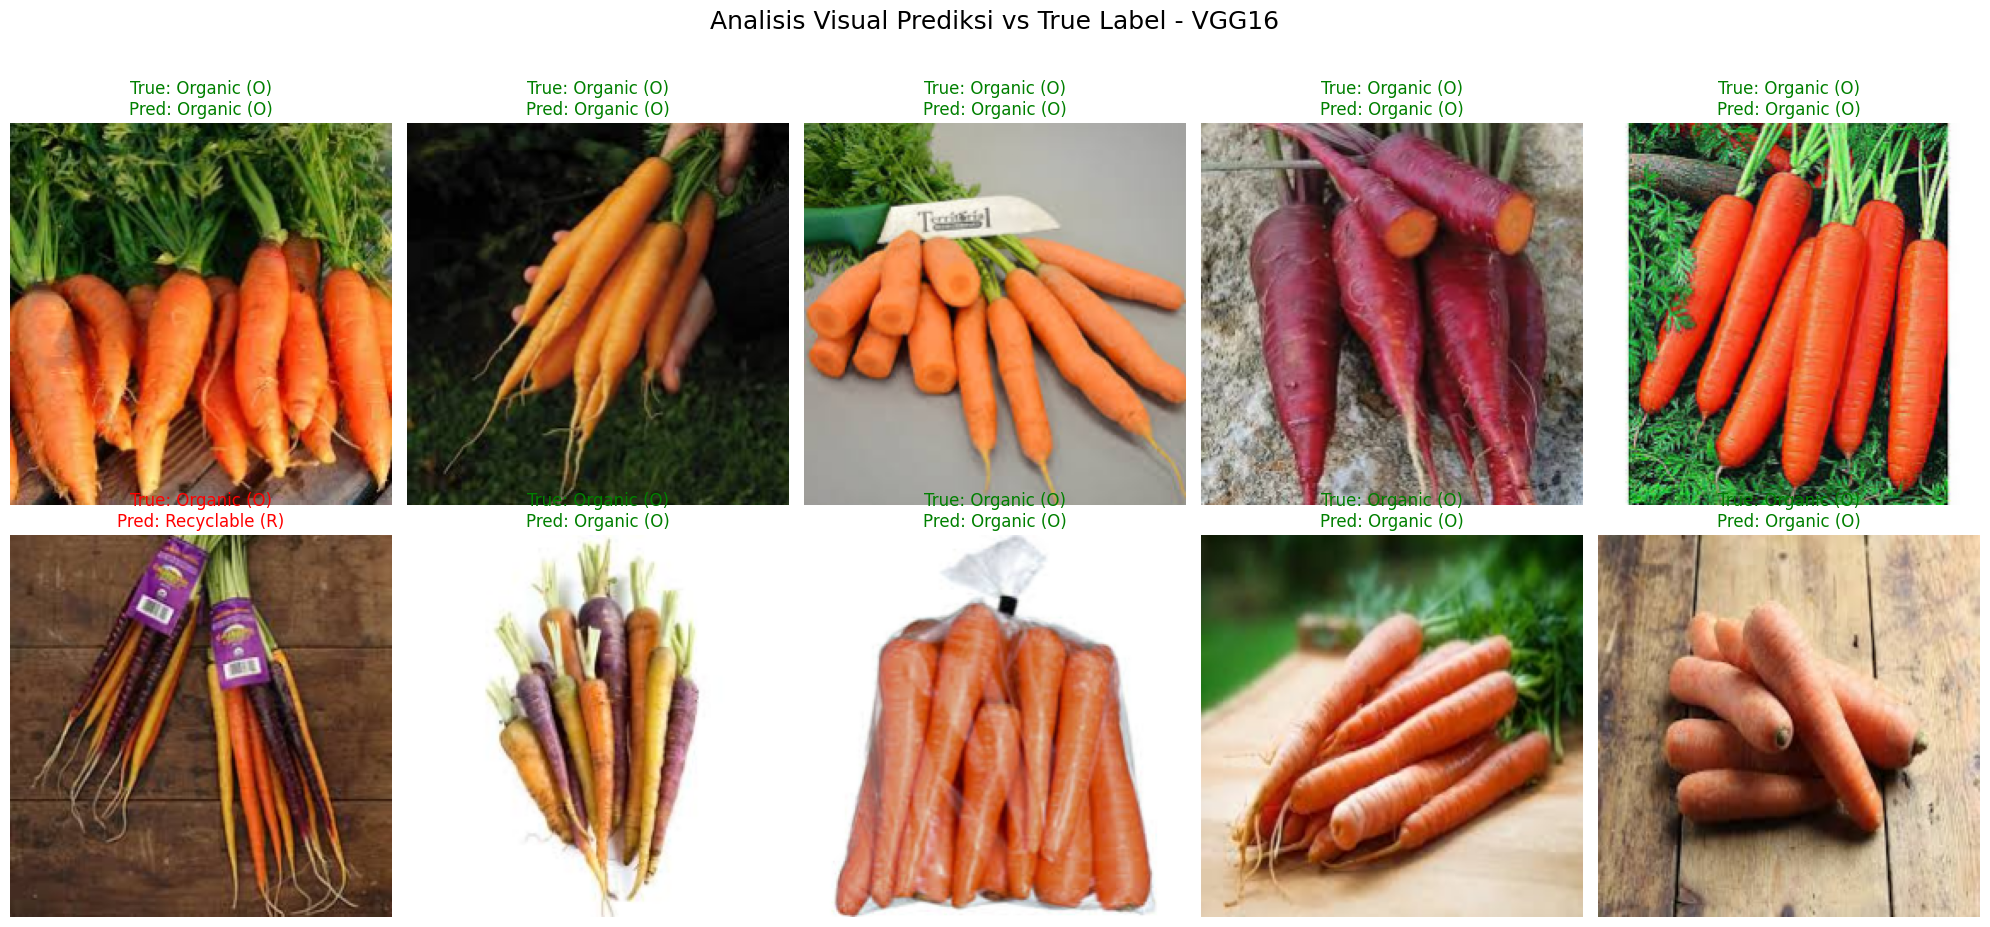

In [ ]:
def visualisasi_prediksi_vs_asli(model, model_name, test_loader, device, num_images=10):
    # 1. Pastikan model menggunakan bobot terbaik hasil training
    model.load_state_dict(torch.load(f"outputs/{model_name}_best.pth"))
    model.to(device)
    model.eval()
    
    class_names = ['Organic (O)', 'Recyclable (R)']
    images_handeled = 0
    
    # Set ukuran figure (misal 2 baris, 5 kolom)
    rows = 2
    cols = 5
    plt.figure(figsize=(20, 10))
    
    # 2. Iterasi untuk mengambil data secara acak
    with torch.no_grad():
        for imgs, lbls in test_loader:
            # Pindahkan ke device
            imgs_dev = imgs.to(device)
            outputs = model(imgs_dev)
            preds = outputs.argmax(1)
            
            for i in range(len(imgs)):
                if images_handeled >= num_images:
                    break
                
                images_handeled += 1
                plt.subplot(rows, cols, images_handeled)
                
                # Konversi tensor ke format gambar (H, W, C)
                img = imgs[i].permute(1, 2, 0).cpu().numpy()
                # Denormalisasi sederhana untuk tampilan
                img = (img - img.min()) / (img.max() - img.min())
                
                plt.imshow(img)
                
                actual = class_names[int(lbls[i])]
                predicted = class_names[preds[i]]
                
                # Warna teks: Hijau jika benar, Merah jika salah
                color = "green" if actual == predicted else "red"
                
                plt.title(f"True: {actual}\nPred: {predicted}", color=color, fontsize=12)
                plt.axis("off")
            
            if images_handeled >= num_images:
                break

    plt.suptitle(f"Analisis Visual Prediksi vs True Label - {model_name}", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Jalankan untuk VGG16
visualisasi_prediksi_vs_asli(model_vgg16, "VGG16", test_loader, device)

## **Model MobileNetV2**

### **Build Model**

In [ ]:
def build_mobilenet_v2(num_classes=2):
    # 1. Gunakan try-except untuk menangani perbedaan versi torchvision
    try:
        # Untuk torchvision terbaru (>= 0.13)
        from torchvision.models import MobileNet_V2_Weights
        model = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
    except (ImportError, AttributeError):
        # Untuk torchvision versi lama (< 0.13)
        model = models.mobilenet_v2(pretrained=True)
    
    # 2. FREEZING (Membekukan fitur ekstraktor)
    for param in model.features.parameters():
        param.requires_grad = False
        
    # 3. MODIFIKASI CLASSIFIER
    # MobileNetV2 memiliki classifier berupa struktur: (0): Dropout, (1): Linear
    num_ftrs = model.classifier[1].in_features
    
    # Ganti dengan layer Linear baru (Output = 2)
    model.classifier[1] = nn.Linear(num_ftrs, num_classes)
    
    return model

# Inisialisasi
model_mobilenet = build_mobilenet_v2(num_classes=2)

# Cek jumlah parameter yang dilatih
total_params = sum(p.numel() for p in model_mobilenet.parameters() if p.requires_grad)
print(f"Total Trainable Params: {total_params:,}")

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\Nadzrul/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:01<00:00, 9.90MB/s]

Total Trainable Params: 2,562


In [ ]:
# Hapus variabel model sebelumnya jika masih ada di workspace
if 'model_base' in globals():
    del model_base

# Paksa pembersihan RAM dan VRAM
gc.collect()
torch.cuda.empty_cache()

print("Memori GPU telah dibersihkan. Siap untuk training MobileNetV2.")

Memori GPU telah dibersihkan. Siap untuk training MobileNetV2.


In [36]:
# Pastikan model_mobilenet sudah di-build di sel sebelumnya
target_models = [
    ("MobileNetV2", model_mobilenet),
]

for name, m in target_models:
    print(f"\n>>> Memulai Training: {name}")
    history = run_train_maraton(
        model=m, 
        model_name=name, 
        train_loader=train_loader, 
        val_loader=val_loader, 
        epochs=10, 
        patience=3
    )
    
    # Bersihkan memori setelah selesai satu model
    gc.collect()
    torch.cuda.empty_cache()

print("\nTraining MobileNetV2 Selesai!")


>>> Memulai Training: MobileNetV2
[MobileNetV2] Epoch 1: Loss 0.4217, Acc 0.8442, Val Loss 0.3265
[MobileNetV2] Epoch 2: Loss 0.2866, Acc 0.8947, Val Loss 0.2672
[MobileNetV2] Epoch 3: Loss 0.2570, Acc 0.9022, Val Loss 0.2408
[MobileNetV2] Epoch 4: Loss 0.2464, Acc 0.9064, Val Loss 0.2347
[MobileNetV2] Epoch 5: Loss 0.2345, Acc 0.9098, Val Loss 0.2182
[MobileNetV2] Epoch 6: Loss 0.2276, Acc 0.9142, Val Loss 0.2216
[MobileNetV2] Epoch 7: Loss 0.2304, Acc 0.9100, Val Loss 0.2131
[MobileNetV2] Epoch 8: Loss 0.2177, Acc 0.9162, Val Loss 0.2214
[MobileNetV2] Epoch 9: Loss 0.2181, Acc 0.9165, Val Loss 0.2153
[MobileNetV2] Epoch 10: Loss 0.2178, Acc 0.9175, Val Loss 0.2045

Training MobileNetV2 Selesai!


### **Visualisasi Hasil Training**

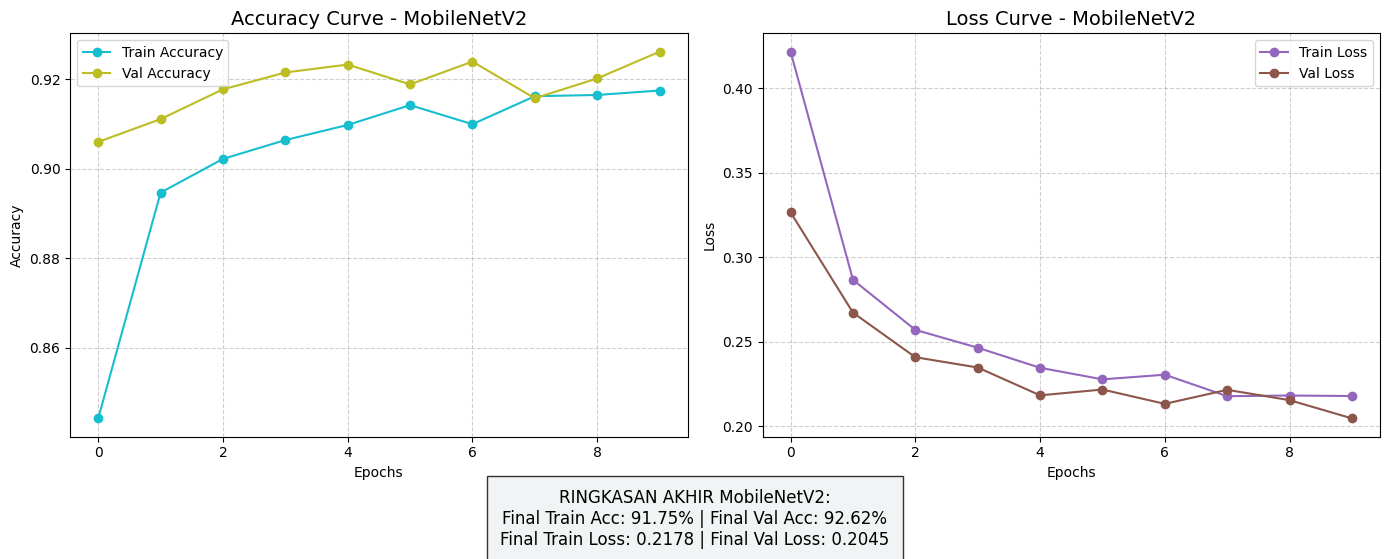

In [ ]:
def plot_mobilenet_results(model_name="MobileNetV2"):
    # 1. Load data history
    try:
        history = np.load(f"outputs/history_{model_name}.npy", allow_pickle=True).item()
    except FileNotFoundError:
        print(f"File history_{model_name}.npy tidak ditemukan!")
        return
    
    # Ambil nilai terakhir
    final_train_acc = history['accuracy'][-1]
    final_val_acc = history['val_accuracy'][-1]
    final_train_loss = history['loss'][-1]
    final_val_loss = history['val_loss'][-1]
    
    # 2. Setup Figure
    plt.figure(figsize=(14, 5))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy', marker='o', color='#17becf')
    plt.plot(history['val_accuracy'], label='Val Accuracy', marker='o', color='#bcbd22')
    plt.title(f'Accuracy Curve - {model_name}', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss', marker='o', color='#9467bd')
    plt.plot(history['val_loss'], label='Val Loss', marker='o', color='#8c564b')
    plt.title(f'Loss Curve - {model_name}', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    
    # 3. Keterangan Akurasi di Bawah Grafik
    summary_text = (f"RINGKASAN AKHIR {model_name}:\n"
                    f"Final Train Acc: {final_train_acc*100:.2f}% | Final Val Acc: {final_val_acc*100:.2f}%\n"
                    f"Final Train Loss: {final_train_loss:.4f} | Final Val Loss: {final_val_loss:.4f}")
    
    plt.figtext(0.5, -0.1, summary_text, ha="center", fontsize=12, 
                bbox={"facecolor":"#eef2f3", "alpha":0.8, "pad":10})
    
    plt.tight_layout()
    plt.show()

# Jalankan visualisasi
plot_mobilenet_results("MobileNetV2")

### **Evaluasi Model**

Mengevaluasi MobileNetV2 pada data test...

RESULT: MobileNetV2
                precision    recall  f1-score   support

   Organic (O)       0.92      0.95      0.94      1401
Recyclable (R)       0.94      0.89      0.92      1112

      accuracy                           0.93      2513
     macro avg       0.93      0.92      0.93      2513
  weighted avg       0.93      0.93      0.93      2513



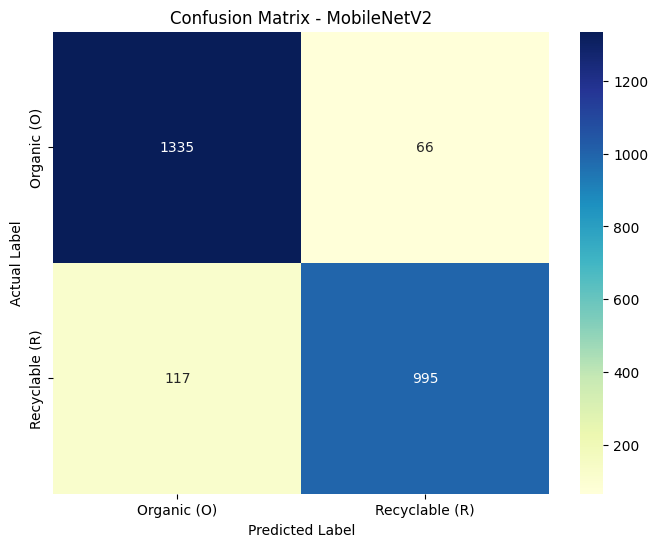

In [ ]:
def evaluate_final_mobilenet(model, model_name, test_loader, device):
    # 1. Load Bobot Terbaik
    model.load_state_dict(torch.load(f"outputs/{model_name}_best.pth"))
    model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    # 2. Ambil Prediksi
    print(f"Mengevaluasi {model_name} pada data test...")
    with torch.no_grad():
        for imgs, lbls in test_loader:
            imgs = imgs.to(device)
            out = model(imgs)
            preds = out.argmax(1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(lbls.numpy())
    
    # 3. Print Report
    print("\n" + "="*60)
    print(f"RESULT: {model_name}")
    print("="*60)
    target_names = ['Organic (O)', 'Recyclable (R)']
    print(classification_report(all_labels, all_preds, target_names=target_names))
    
    # 4. Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', 
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Jalankan Evaluasi
evaluate_final_mobilenet(model_mobilenet, "MobileNetV2", test_loader, device)

### **Prediksi Label Asli vs Prediksi**

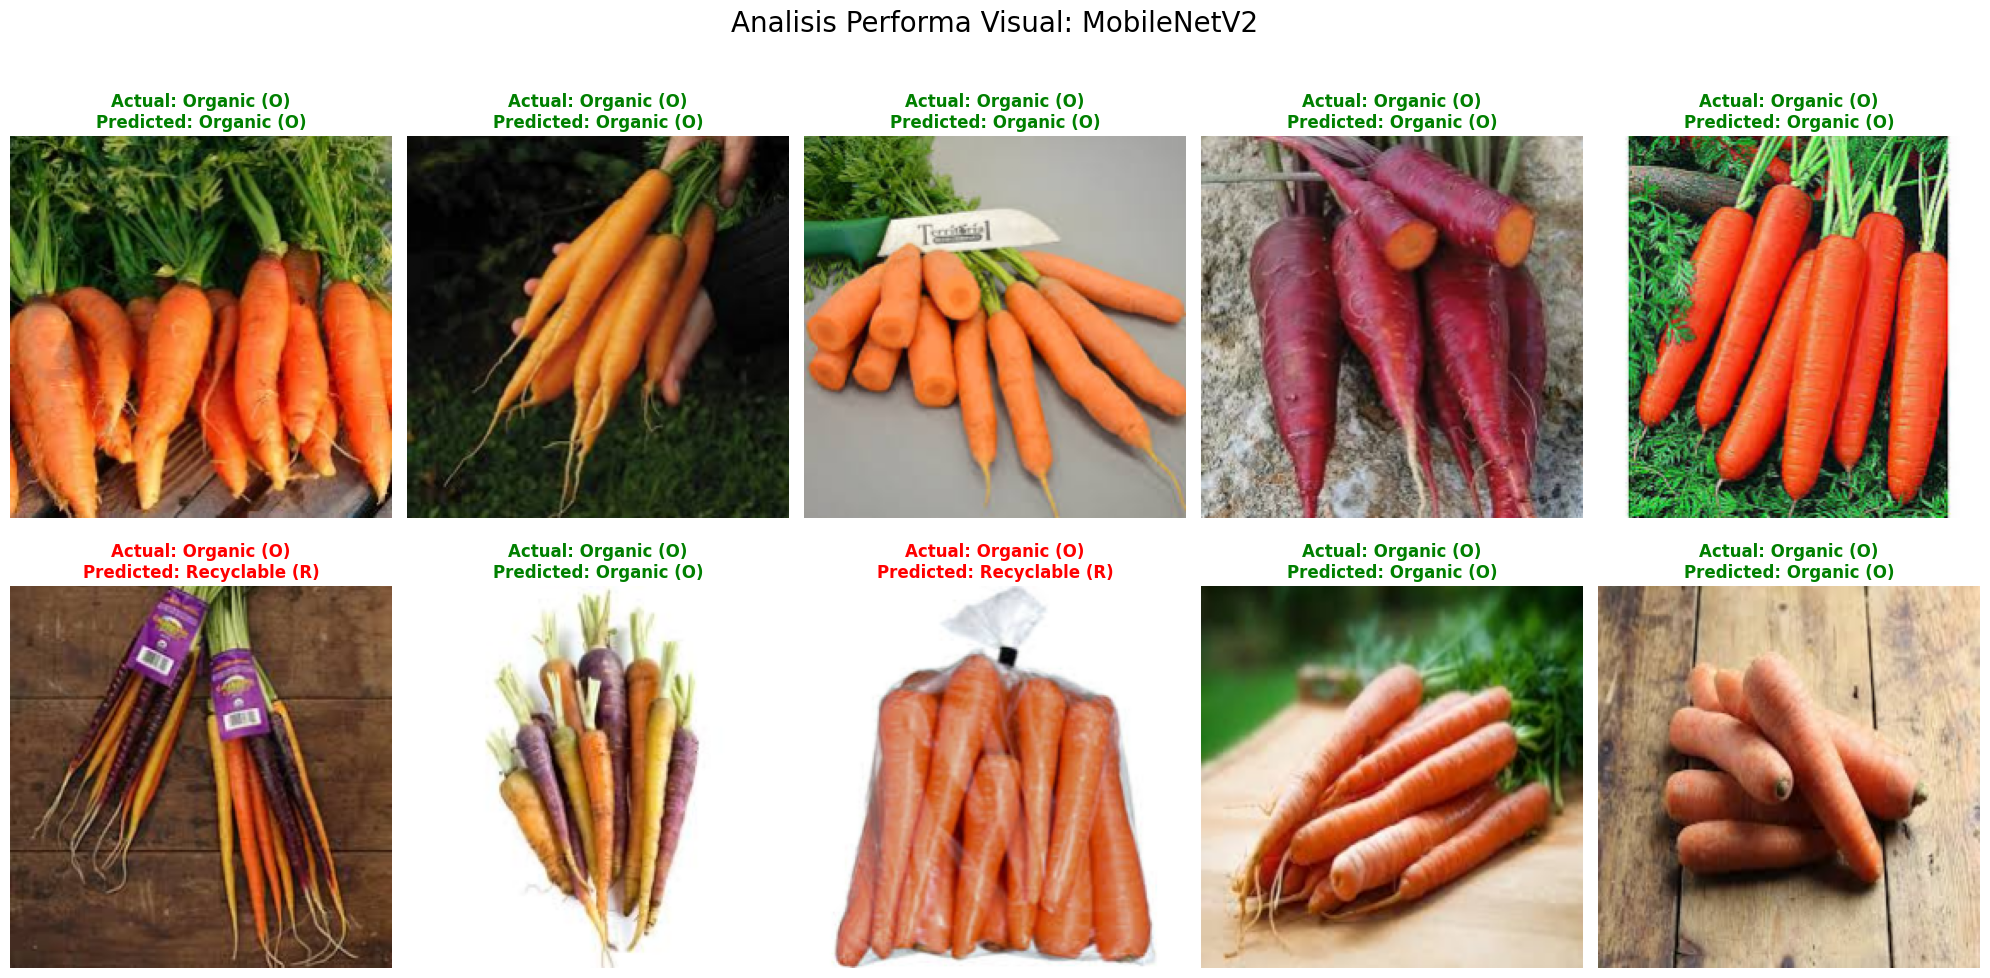

In [ ]:
def visualisasi_final_komparasi(model, model_name, test_loader, device, num_images=10):
    # 1. Load weights terbaik
    model.load_state_dict(torch.load(f"outputs/{model_name}_best.pth"))
    model.to(device)
    model.eval()
    
    class_names = ['Organic (O)', 'Recyclable (R)']
    
    # 2. Ambil data dari test_loader
    images, labels = next(iter(test_loader))
    
    # 3. Prediksi
    with torch.no_grad():
        outputs = model(images.to(device))
        preds = outputs.argmax(1)
    
    # 4. Plotting Grid
    plt.figure(figsize=(20, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(2, 5, i + 1)
        
        # Denormalisasi gambar untuk tampilan
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = (img - img.min()) / (img.max() - img.min())
        
        plt.imshow(img)
        
        actual = class_names[int(labels[i])]
        predicted = class_names[preds[i]]
        
        # Hijau jika benar, Merah jika salah
        color = "green" if actual == predicted else "red"
        
        plt.title(f"Actual: {actual}\nPredicted: {predicted}", color=color, fontsize=12, fontweight='bold')
        plt.axis("off")
    
    plt.suptitle(f"Analisis Performa Visual: {model_name}", fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

# Jalankan evaluasi visual
visualisasi_final_komparasi(model_mobilenet, "MobileNetV2", test_loader, device)

Model  Train Acc (%)  Val Acc (%)  Test Acc (%)  Inf. Time (ms)  \
0     Base_CNN          85.70        85.62         86.47            6.74   
1        VGG16          95.78        93.42         91.44           15.24   
2  MobileNetV2          91.75        92.62         92.72            7.22   

   Size (MB)  
0      42.61  
1     512.21  
2       8.73

✅ Data disimpan ke 'outputs/full_model_comparison.csv'


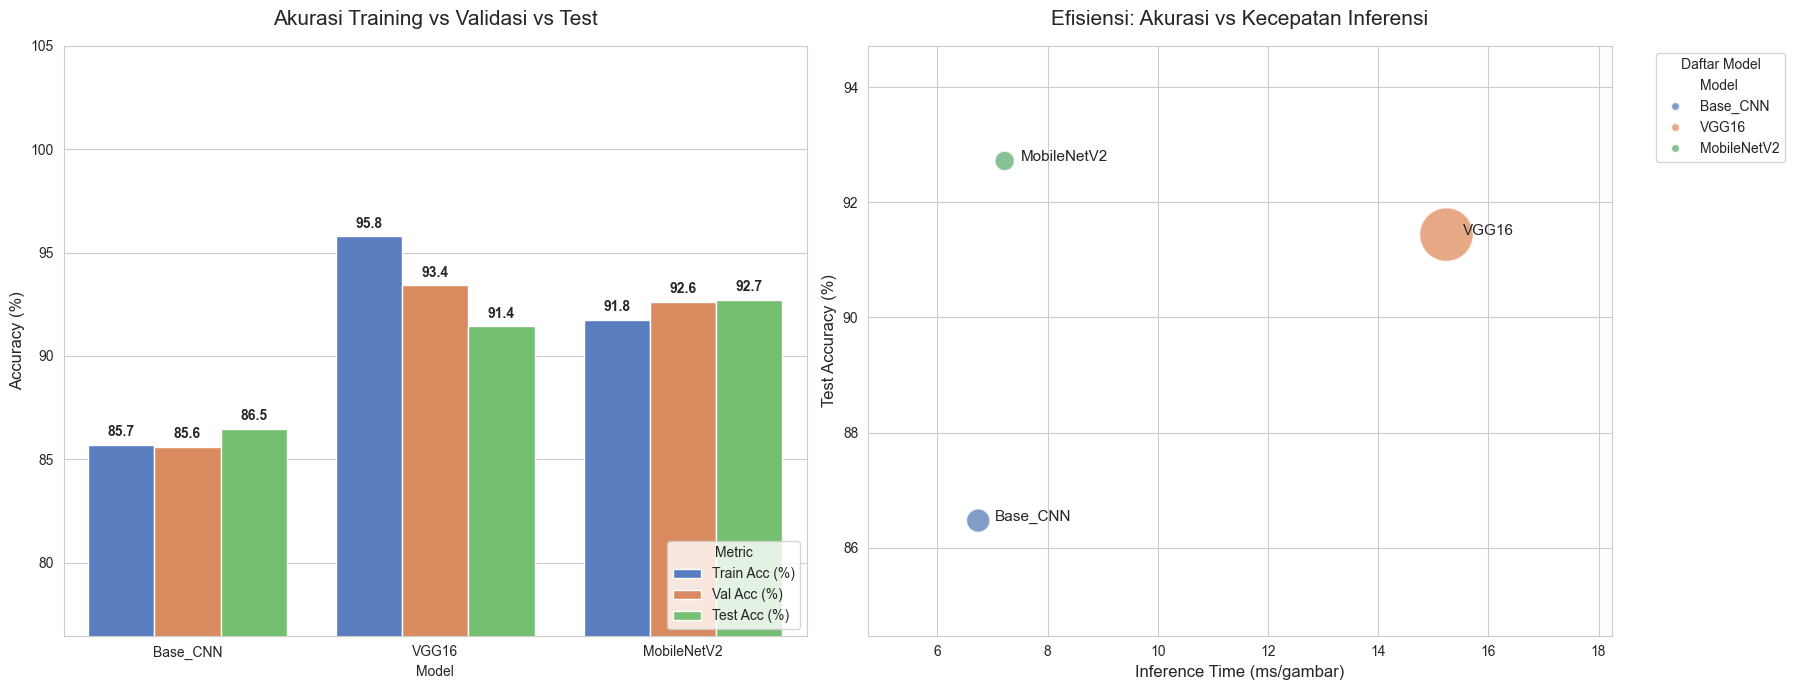

In [ ]:
def visualize_full_report(df):
    # 1. Simpan CSV untuk kebutuhan deployment
    df.to_csv("outputs/full_model_comparison.csv", index=False)
    print("✅ Data disimpan ke 'outputs/full_model_comparison.csv'")
    
    # 2. Setup Figure dengan 2 Subplot
    plt.figure(figsize=(18, 7))
    sns.set_style("whitegrid")
    
    # --- SUBPLOT 1: Grouped Bar Chart (Perbandingan Akurasi) ---
    plt.subplot(1, 2, 1)
    
    # Mengubah format data (Melt) agar cocok untuk Grouped Bar Chart
    df_melted = df.melt(id_vars='Model', 
                        value_vars=['Train Acc (%)', 'Val Acc (%)', 'Test Acc (%)'], 
                        var_name='Tahap', value_name='Accuracy')
    
    bar_plot = sns.barplot(x='Model', y='Accuracy', hue='Tahap', data=df_melted, palette='muted')
    
    # Mengatur batas Y agar perbedaan terlihat jelas
    plt.ylim(df['Test Acc (%)'].min() - 10, 105)
    plt.title('Akurasi Training vs Validasi vs Test', fontsize=15, pad=15)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.legend(title='Metric', loc='lower right')
    
    # Menambahkan label angka di atas setiap bar
    for p in bar_plot.patches:
        if p.get_height() > 0:
            bar_plot.annotate(format(p.get_height(), '.1f'), 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', 
                           xytext = (0, 9), 
                           textcoords = 'offset points',
                           fontsize=10, fontweight='bold')

    # --- SUBPLOT 2: Bubble Chart (Efisiensi Model) ---
    plt.subplot(1, 2, 2)
    
    # Normalisasi visual ukuran agar tidak berantakan
    df_vis = df.copy()
    df_vis['Visual_Size'] = df_vis['Size (MB)'].clip(upper=1000)
    
    scatter = sns.scatterplot(
        x='Inf. Time (ms)', 
        y='Test Acc (%)', 
        size='Visual_Size',
        hue='Model', 
        data=df_vis, 
        sizes=(200, 1500), # Mengatur skala bulatan
        alpha=0.7,
        palette='deep'
    )
    
    # Memberikan ruang pada sumbu grafik
    plt.xlim(df_vis['Inf. Time (ms)'].min() - 2, df_vis['Inf. Time (ms)'].max() + 3)
    plt.ylim(df_vis['Test Acc (%)'].min() - 2, df_vis['Test Acc (%)'].max() + 2)
    
    plt.title('Efisiensi: Akurasi vs Kecepatan Inferensi', fontsize=15, pad=15)
    plt.xlabel('Inference Time (ms/gambar)', fontsize=12)
    plt.ylabel('Test Accuracy (%)', fontsize=12)
    
    # Memberi label nama model di dekat bulatan
    for i in range(df_vis.shape[0]):
        plt.text(df_vis['Inf. Time (ms)'][i] + 0.3, df_vis['Test Acc (%)'][i], df_vis['Model'][i], 
                 fontsize=11, fontweight='medium')

    # Merapikan legenda
    handles, labels = scatter.get_legend_handles_labels()
    plt.legend(handles[:4], labels[:4], title="Daftar Model", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig("outputs/full_comparison_plot.png", bbox_inches='tight')
    plt.show()

# Tampilkan Tabel
display(comparison_df)

# Jalankan Visualisasi
visualize_full_report(comparison_df)